In [860]:
# Import required libraries
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import parallel_backend, Memory
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report,confusion_matrix

In [861]:
# Read the dataset
dataset = pd.read_csv('airlines.csv')

In [862]:
# Function to show number of rows and columns
def count_rows_columns():
    r, c = dataset.shape
    return f'The dataset has {r} rows and {c} columns'

In [863]:
# Get the number of rows and column in the dataset 
count_rows_columns()

'The dataset has 539383 rows and 9 columns'

In [864]:
# Get the columns name and the sample data 
dataset.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [865]:
# Check for missing values 
dataset.isnull().sum()

id             0
Airline        0
Flight         0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Time           0
Length         0
Delay          0
dtype: int64

In [866]:
# Drop the id column
dataset.drop('id', axis=1, inplace=True)
dataset.head(1)

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,CO,269,SFO,IAH,3,15,205,1


In [867]:
# Get the maximum and minimum values for the numerical columns 
max_values = dataset[['Flight','DayOfWeek', 'Time', 'Length']].max()
min_values =  dataset[['Flight','DayOfWeek', 'Time', 'Length']].min()

print("Maximum values:")
print(max_values)

print("\nMinimum values:")
print(min_values)

Maximum values:
Flight       7814
DayOfWeek       7
Time         1439
Length        655
dtype: int64

Minimum values:
Flight        1
DayOfWeek     1
Time         10
Length        0
dtype: int64


In [868]:
# Get the rows with flight lenght zero
flight_length = dataset[dataset['Length'] == 0]
flight_length

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
179149,F9,106,DEN,MSP,6,635,0,0
182840,F9,107,MSP,DEN,6,851,0,0
188953,F9,103,MSP,DEN,7,375,0,0
445578,B6,493,BOS,SEA,7,1060,0,1


In [869]:
# Drop rows with flight flight length zero
dataset.drop(dataset[dataset['Length'] == 0].index, inplace=True)
# Get the number of rows and column in the dataset 
count_rows_columns()

'The dataset has 539379 rows and 8 columns'

In [870]:
# Get the number of unique values
unique_airlines = dataset['Airline'].nunique()
unique_airport_from = dataset['AirportFrom'].nunique()
unique_airport_to = dataset['AirportTo'].nunique()

print(f'{unique_airlines} Airlines, '
      f'operating from {unique_airport_from} airports and'
            f' operating to {unique_airport_to} airports')

18 Airlines, operating from 293 airports and operating to 293 airports


In [871]:
# Get the number of times each airline operated 
airline_counts = dataset['Airline'].value_counts()
airline_counts

WN    94097
DL    60940
OO    50254
AA    45656
MQ    36605
US    34500
XE    31126
EV    27983
UA    27619
CO    21118
FL    20827
9E    20686
B6    18111
YV    13725
OH    12630
AS    11471
F9     6453
HA     5578
Name: Airline, dtype: int64

In [872]:
# Get the number of times each airport was operated from
airport_from = dataset['AirportFrom'].value_counts()
airport_from

# airport_from.to_csv('airportFrom.csv')

ATL    34449
ORD    24822
DFW    22154
DEN    19842
LAX    16657
       ...  
MMH       16
SJT       15
GUM       10
ADK        9
ABR        2
Name: AirportFrom, Length: 293, dtype: int64

In [873]:
# Get the number of times each airport was operated from
airport_to = dataset['AirportTo'].value_counts()
airport_to

# airport_to.to_csv('airportTo.csv')

ATL    34440
ORD    24871
DFW    22153
DEN    19846
LAX    16656
       ...  
MMH       16
SJT       15
GUM       10
ADK        9
ABR        2
Name: AirportTo, Length: 293, dtype: int64

In [874]:
# Group by 'Airline', 'AirportFrom', and 'AirportTo', and check if there are delays
grouped_data = dataset.groupby(['Airline', 'AirportFrom', 'AirportTo', 'Delay']) \
                      .size().unstack(fill_value=0)

# Calculate the sum of delays for each group
grouped_data['Total Flights'] = dataset.groupby(['Airline', 'AirportFrom', 'AirportTo'])['Delay'].count()

# Rename columns
grouped_data.rename(columns={0: 'Not Delayed', 1: 'Delayed'}, inplace=True)

grouped_data
# grouped_data.to_csv('grouped_data.csv')

Delay                          Not Delayed  Delayed  Total Flights
Airline AirportFrom AirportTo                                     
9E      ABE         DTW                 45       40             85
        ABR         MSP                  1        1              2
        ALB         ATL                 32        9             41
                    DTW                 51       39             90
                    JFK                 28        3             31
...                                    ...      ...            ...
YV      SYR         IAD                 30       17             47
                    ORD                 27        8             35
        TEX         PHX                 23        4             27
        TUS         PHX                245       21            266
        YUM         PHX                158       30            188

[6836 rows x 3 columns]

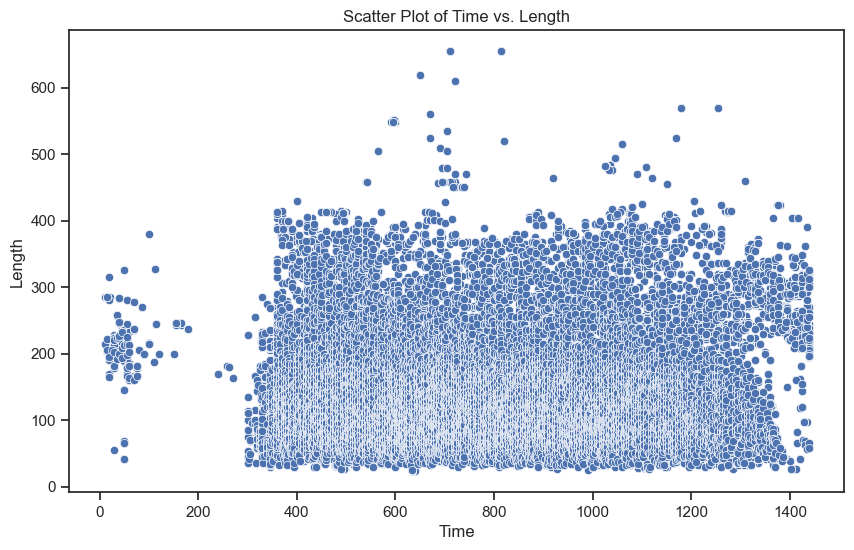

In [875]:

# Scatter plot for 'Time' vs. 'Length' before removing outliers 
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Time', y='Length', data=dataset)
plt.title('Scatter Plot of Time vs. Length')
plt.xlabel('Time')
plt.ylabel('Length')
plt.show()


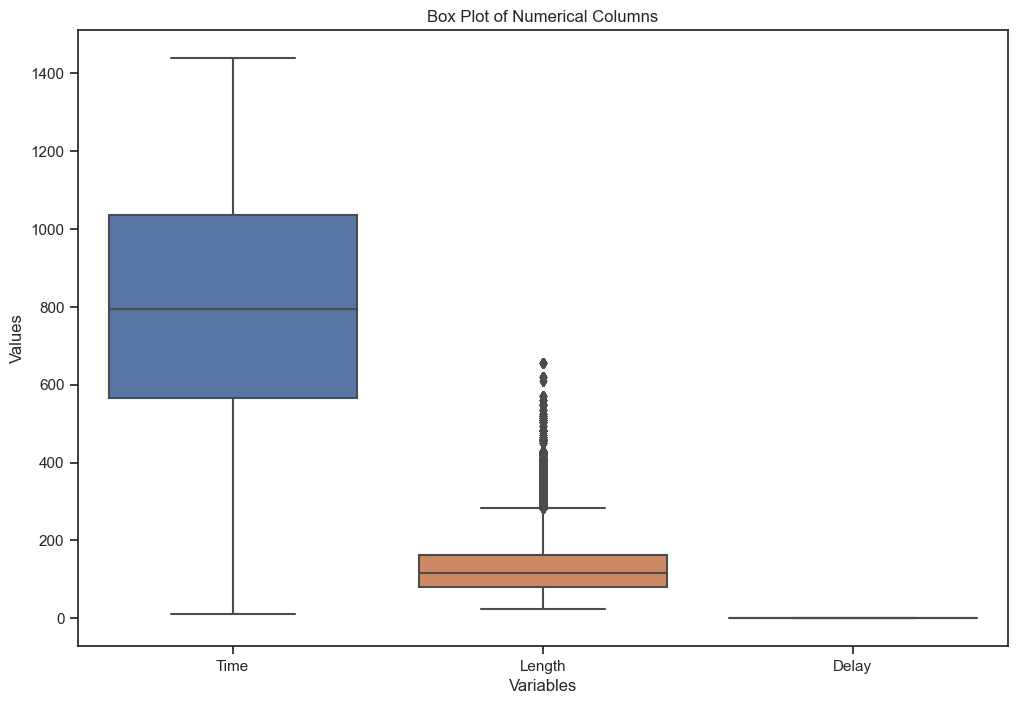

In [876]:
# Box plot for 'Time', 'Length', and 'Delay'
numerical_columns = ['Time', 'Length', 'Delay']
plt.figure(figsize=(12, 8))
sns.boxplot(data=dataset[numerical_columns])
plt.title('Box Plot of Numerical Columns')
plt.xlabel('Variables')
plt.ylabel('Values')
plt.show()

In [877]:
# Select numerical columns for outlier detection
numerical_columns = ['Time', 'Length', 'Delay']

outliers_exist = True
iterations = 0

while outliers_exist:
    # Calculate the IQR for each numerical column
    Q1 = dataset[numerical_columns].quantile(0.25)
    Q3 = dataset[numerical_columns].quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers = ((dataset[numerical_columns] < (Q1 - 1.5 * IQR)) | (dataset[numerical_columns] > (Q3 + 1.5 * IQR))).any(axis=1)

    # Check if outliers exist
    outliers_exist = outliers.any()

    if outliers_exist:
        # Reset the index of the dataset and drop outliers
        dataset.reset_index(drop=True, inplace=True)
        outliers.reset_index(drop=True, inplace=True)

        # Filter the dataset to keep only the rows without outliers
        dataset = dataset[~outliers]

        iterations += 1

# Print the rows with outliers
print('Number of outliers')
print(dataset[outliers].count())
print('-----------------------------------------------')
print('After outliers have been removed ')
print(f'Number of iterations: {iterations}')
print('-----------------------------------------------')
print(dataset)


Number of outliers
Airline        0
Flight         0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Time           0
Length         0
Delay          0
dtype: int64
-----------------------------------------------
After outliers have been removed 
Number of iterations: 6
-----------------------------------------------
       Airline  Flight AirportFrom AirportTo  DayOfWeek  Time  Length  Delay
0           CO     269         SFO       IAH          3    15     205      1
1           US    1558         PHX       CLT          3    15     222      1
2           AA    2400         LAX       DFW          3    20     165      1
3           AA    2466         SFO       DFW          3    20     195      1
4           AS     108         ANC       SEA          3    30     202      0
...        ...     ...         ...       ...        ...   ...     ...    ...
503136      DL    2354         LAX       ATL          5  1435     255      0
503137      FL      58         LAX       ATL          5  1435 

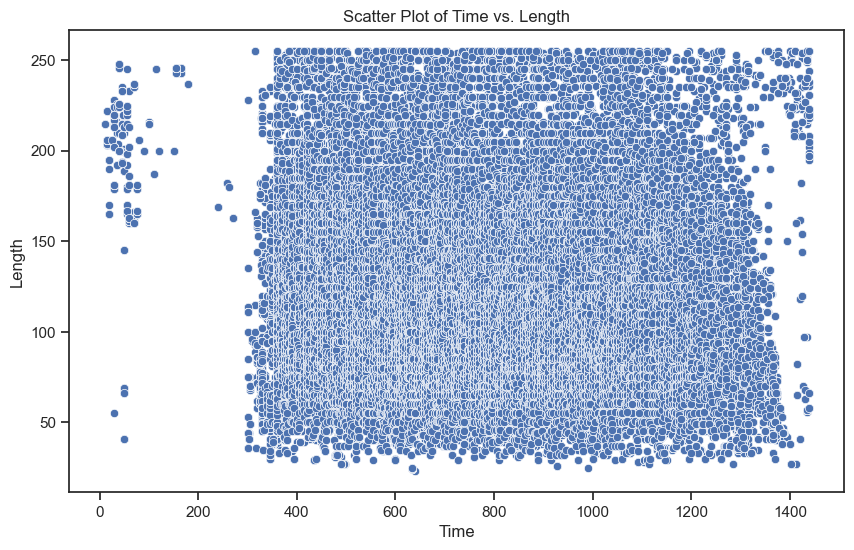

In [878]:
# Scatter plot for 'Time' vs. 'Length'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Time', y='Length', data=dataset)
plt.title('Scatter Plot of Time vs. Length')
plt.xlabel('Time')
plt.ylabel('Length')
plt.show()




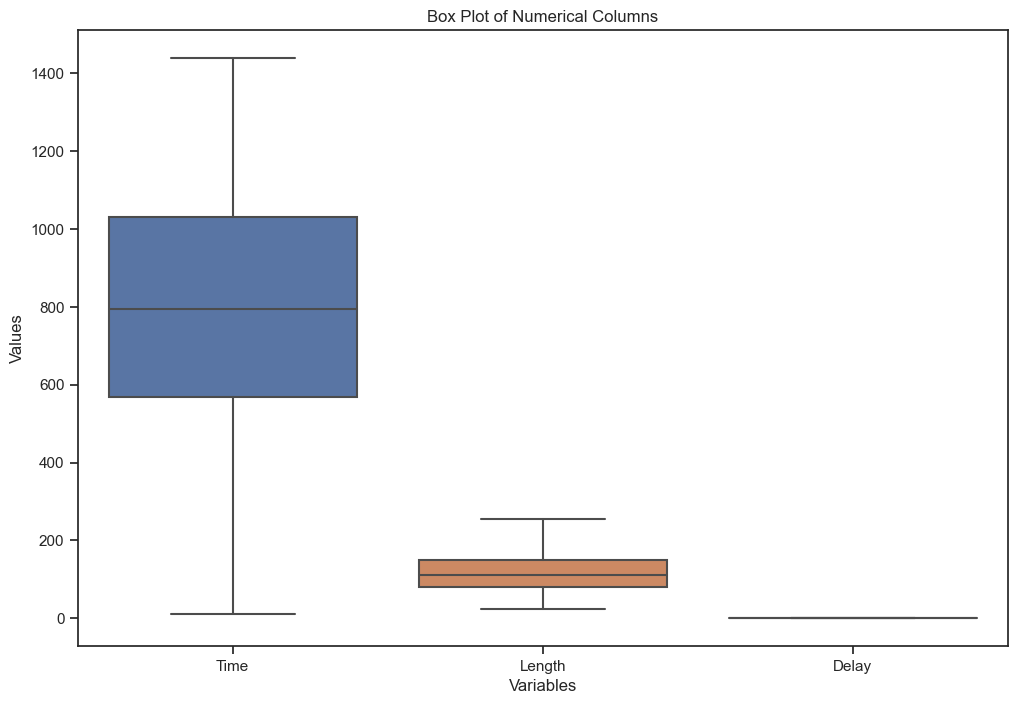

In [879]:
# Box plot for 'Time', 'Length', and 'Delay'
plt.figure(figsize=(12, 8))
sns.boxplot(data=dataset[numerical_columns])
plt.title('Box Plot of Numerical Columns')
plt.xlabel('Variables')
plt.ylabel('Values')
plt.show()

## FEATURE ENGINEERING

In [880]:
# Calculate flight density per airline
flight_density_per_airline = dataset.groupby('Airline').size().reset_index(name='FlightDensity')

# Merge the flight density back into the original dataset based on 'Airline'
dataset = pd.merge(dataset, flight_density_per_airline, on='Airline')

dataset.head()

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,FlightDensity
0,CO,269,SFO,IAH,3,15,205,1,17307
1,CO,1094,LAX,IAH,3,30,181,1,17307
2,CO,223,ANC,SEA,3,49,201,1,17307
3,CO,1496,LAS,IAH,3,60,162,0,17307
4,CO,507,ONT,IAH,3,75,167,0,17307


In [881]:
# Route density per airline
# Combine 'AirportFrom' and 'AirportTo' to create a route

# Calculate the 'Route' combining 'AirportFrom' and 'AirportTo'
dataset['Route'] = dataset['AirportFrom'] + ' to ' + dataset['AirportTo']

# Calculate route density per airline
route_density_per_airline = dataset.groupby(['Airline', 'Route']).size().reset_index(name='RouteDensity')

# Merge the 'RouteDensity' back into the original dataset based on 'Airline' and 'Route'
dataset = pd.merge(dataset, route_density_per_airline[['Airline', 'Route', 'RouteDensity']], on=['Airline', 'Route'], how='left')

# Drop the 'Route' column
dataset.drop('Route', axis=1, inplace=True)

dataset.head(1)
# dataset.to_csv('routedensity.csv')

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,FlightDensity,RouteDensity
0,CO,269,SFO,IAH,3,15,205,1,17307,200


In [882]:
# Get the number of rows and column in the dataset 
count_rows_columns()

'The dataset has 502607 rows and 10 columns'

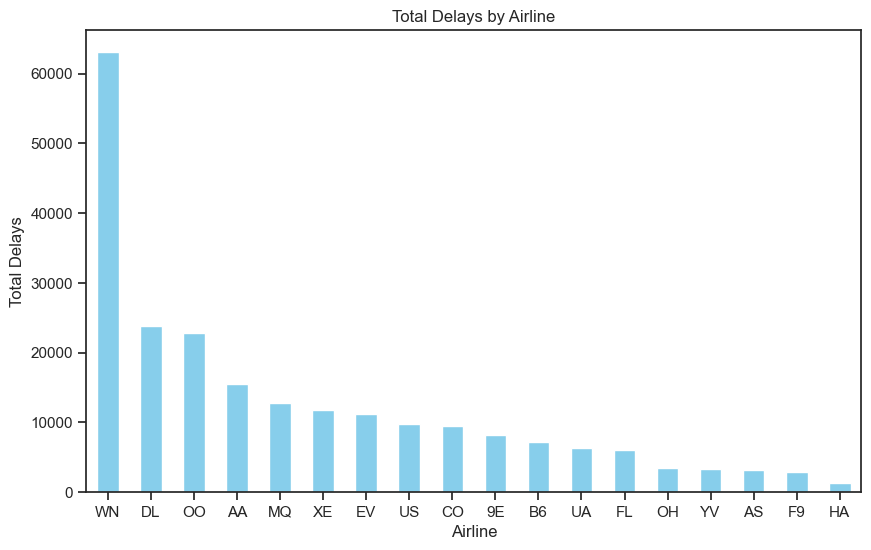

In [883]:
# 1. Which airline has the most delays?

df = dataset
# Calculate the total delays for each airline
airline_delays = dataset.groupby('Airline')['Delay'].sum()

# Sort the airlines based on delays in descending order
airline_delays_sorted = airline_delays.sort_values(ascending=False)

# Create a bar chart
plt.figure(figsize=(10, 6))
airline_delays_sorted.plot(kind='bar', color='skyblue')
plt.xlabel('Airline')
plt.ylabel('Total Delays')
plt.title('Total Delays by Airline')
plt.xticks(rotation=0)  # Ensure airline names are not rotated on the x-axis
plt.show()



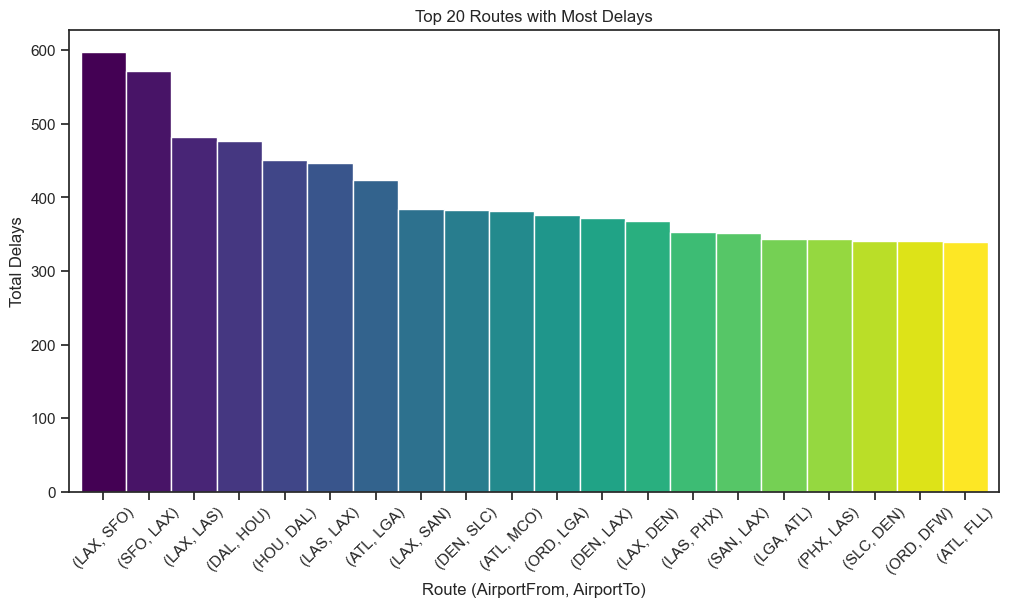

In [884]:
# 2. routes with the most delays

df = dataset

# Calculate the total delays for each route
route_delays = dataset.groupby(['AirportFrom', 'AirportTo'])['Delay'].sum()

# Sort the routes based on delays in descending order
route_delays_sorted = route_delays.sort_values(ascending=False)

# Select the top 20 routes based on delays
top_20_routes = route_delays_sorted.head(20)

# Define a list of colors for the bars
colors = plt.cm.viridis(np.linspace(0, 1, len(top_20_routes)))

# Create a bar chart for the top 20 routes
plt.figure(figsize=(12, 6))
top_20_routes.plot(kind='bar', color=colors,width=1)
plt.xlabel('Route (AirportFrom, AirportTo)')
plt.ylabel('Total Delays')
plt.title('Top 20 Routes with Most Delays')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()


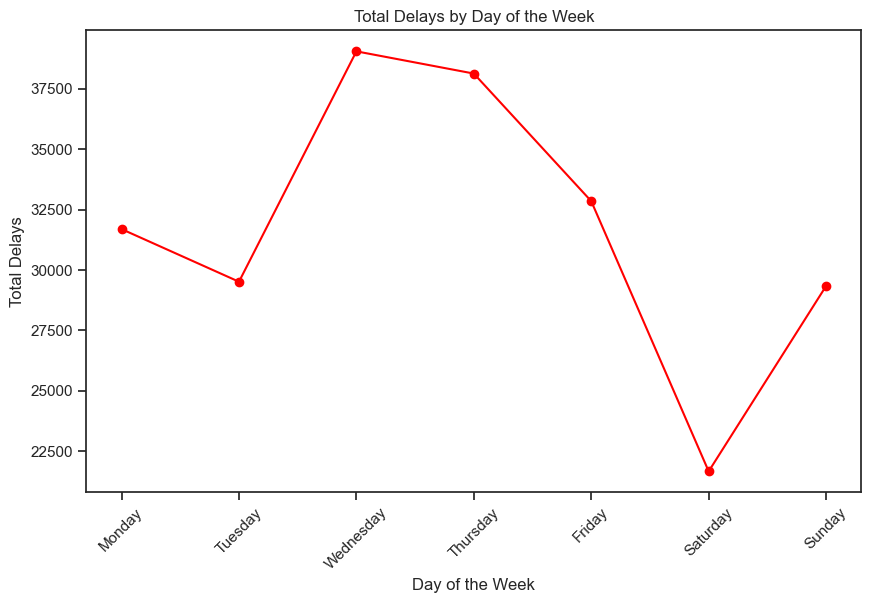

In [885]:
# 3. Which days of the week had the most delays?

# Map numerical day of the week to their names
day_of_week_names = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}

# Calculate the total delays for each day of the week
daily_delays = dataset.groupby('DayOfWeek')['Delay'].sum()

# Replace numeric day of the week with names
daily_delays.index = daily_delays.index.map(day_of_week_names)

# Create a line chart
plt.figure(figsize=(10, 6))
daily_delays.plot(kind='line', marker='o', color='red', linestyle='-')
plt.xlabel('Day of the Week')
plt.ylabel('Total Delays')
plt.title('Total Delays by Day of the Week')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

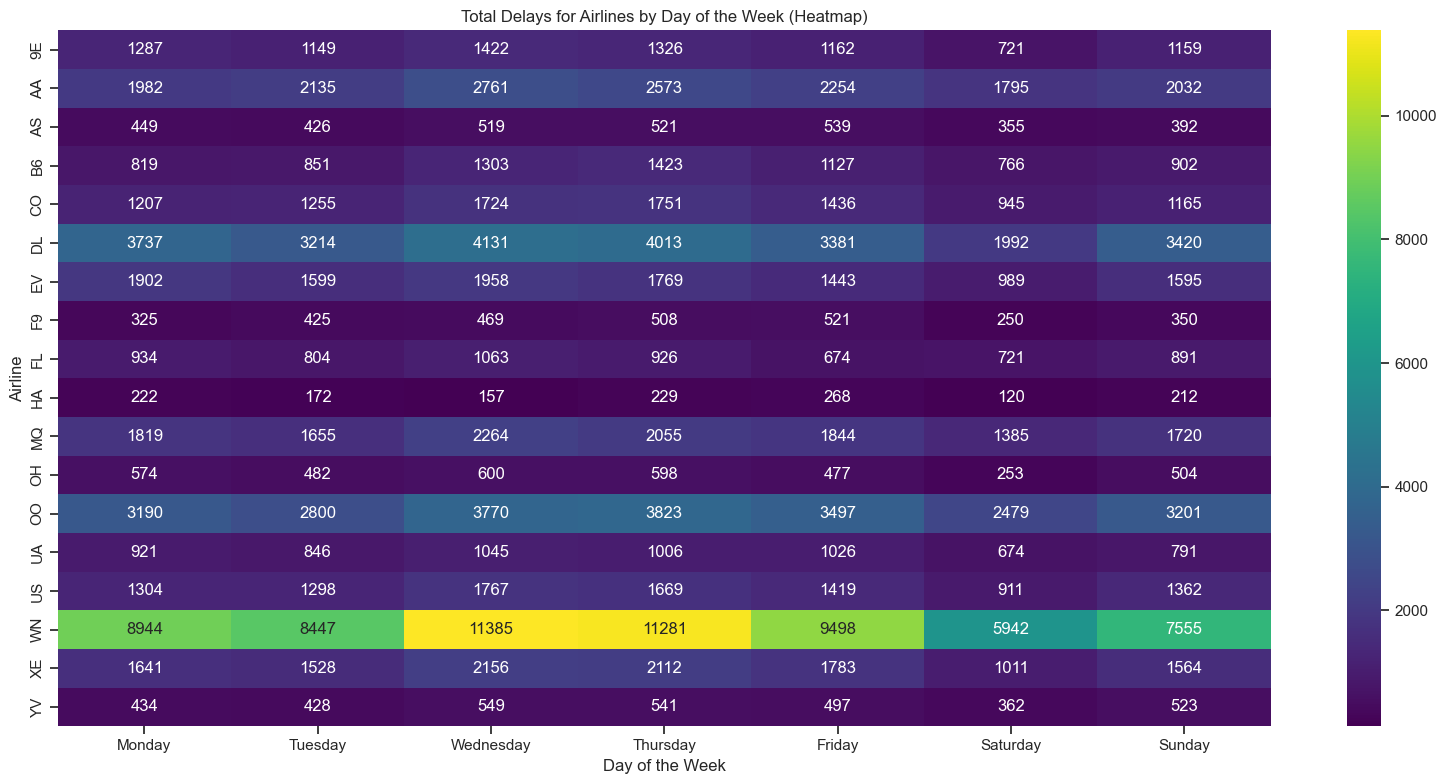

In [886]:
# 4. Which days of the week do airline experience the most delays? 

df= dataset
# Calculate the total delays for each airline on each day of the week
airline_daily_delays = df.groupby(['Airline', 'DayOfWeek'])['Delay'].sum().unstack()

# Replace numeric day of the week with names
airline_daily_delays.columns = airline_daily_delays.columns.map(day_of_week_names)

# Set the style for the heatmap
sns.set(style="ticks")


# Create a heatmap for the airlines
plt.figure(figsize=(16, 8))
sns.heatmap(airline_daily_delays, cmap='viridis', annot=True, fmt='d')
plt.ylabel('Airline')
plt.xlabel('Day of the Week')
plt.title('Total Delays for Airlines by Day of the Week (Heatmap)')
plt.tight_layout()
plt.show()



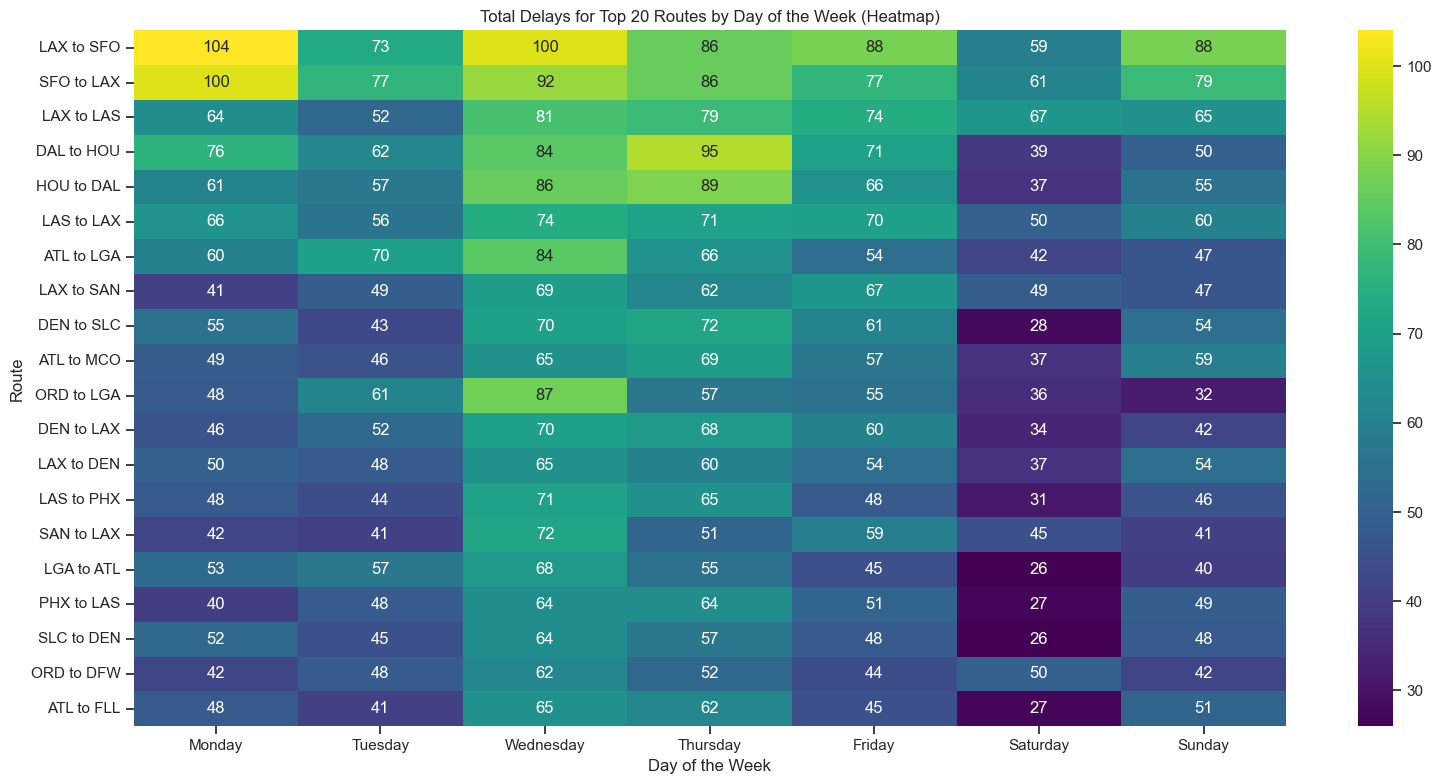

In [887]:
# 5. Which days of the week do routes experience the most delays? 

df = dataset

# Combine AirportFrom and AirportTo to create the route
df['Route'] = df['AirportFrom'] + ' to ' + df['AirportTo']

# Group by route, day of the week, and calculate sum of delays
route_delay_sums = df.groupby(['Route', 'DayOfWeek'])['Delay'].sum().unstack().fillna(0)

# Replace numeric day of the week with names
route_delay_sums.columns = route_delay_sums.columns.map(day_of_week_names)

# Calculate the total delay for each route and sort by delay in descending order
total_delay_per_route = route_delay_sums.sum(axis=1)
top_20_routes = total_delay_per_route.sort_values(ascending=False).head(20)
top_20_delay_sums = route_delay_sums.loc[top_20_routes.index]

# Set the style for the heatmap
sns.set(style="ticks")

# Create a heatmap for the sum of delays by route and day of the week (limited to top 20 routes)
plt.figure(figsize=(16, 8))
sns.heatmap(top_20_delay_sums, cmap='viridis', annot=True, fmt='.0f')
plt.ylabel('Route')
plt.xlabel('Day of the Week')
plt.title('Total Delays for Top 20 Routes by Day of the Week (Heatmap)')
plt.tight_layout()
plt.show()

In [888]:
df = dataset

# Combine AirportFrom and AirportTo to create the route
df['Route'] = df['AirportFrom'] + ' to ' + df['AirportTo']

# Group by route and calculate total flights for each airline
route_airline_counts = df.groupby(['Route', 'Airline']).size().unstack().fillna(0)

# Calculate the total delay for each route and sort by delay in descending order
total_delay_per_route = df.groupby('Route')['Delay'].sum().sort_values(ascending=False)
top_20_routes = total_delay_per_route.head(20)

# Select the top 20 routes and display the airline flight counts for those routes
top_20_airline_counts = route_airline_counts.loc[top_20_routes.index]

print('Table: Airline Flight Counts for the 20 Most Delayed Routes')
top_20_airline_counts

Table: Airline Flight Counts for the 20 Most Delayed Routes


Airline,9E,AA,AS,B6,CO,DL,EV,F9,FL,HA,MQ,OH,OO,UA,US,WN,XE,YV
Route,,,,,,,,,,,,,,,,,,
LAX to SFO,0.0,185.0,0.0,0.0,0.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,441.0,0.0,318.0,0.0,0.0
SFO to LAX,0.0,185.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,71.0,440.0,0.0,317.0,0.0,0.0
LAX to LAS,0.0,123.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,263.0,56.0,63.0,337.0,0.0,74.0
DAL to HOU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,701.0,0.0,0.0
HOU to DAL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,698.0,0.0,0.0
LAS to LAX,0.0,123.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,261.0,57.0,63.0,338.0,0.0,74.0
ATL to LGA,0.0,0.0,0.0,0.0,0.0,474.0,0.0,0.0,237.0,0.0,204.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LAX to SAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,362.0,0.0,573.0,0.0,0.0,0.0,0.0,0.0
DEN to SLC,0.0,0.0,0.0,0.0,0.0,2.0,0.0,59.0,0.0,0.0,0.0,0.0,398.0,20.0,0.0,168.0,0.0,0.0


In [889]:
# Label encoding of categorical variables [Airline, AirportFrom, AirportTo]

# Initialize label encoders
label_encoder_airline = LabelEncoder()
label_encoder_airport_from = LabelEncoder()
label_encoder_airport_to = LabelEncoder()

# Fit and transform the respective columns
dataset['Airline'] = label_encoder_airline.fit_transform(dataset['Airline'])
dataset['AirportFrom'] = label_encoder_airport_from.fit_transform(dataset['AirportFrom'])
dataset['AirportTo'] = label_encoder_airport_to.fit_transform(dataset['AirportTo'])

dataset.drop('Route', axis=1, inplace=True)

dataset.head()
# dataset.to_csv('routedensity.csv')

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,FlightDensity,RouteDensity
0,4,269,252,134,3,15,205,1,17307,200
1,4,1094,153,134,3,30,181,1,17307,328
2,4,223,14,251,3,49,201,1,17307,77
3,4,1496,152,134,3,60,162,0,17307,212
4,4,507,206,134,3,75,167,0,17307,92


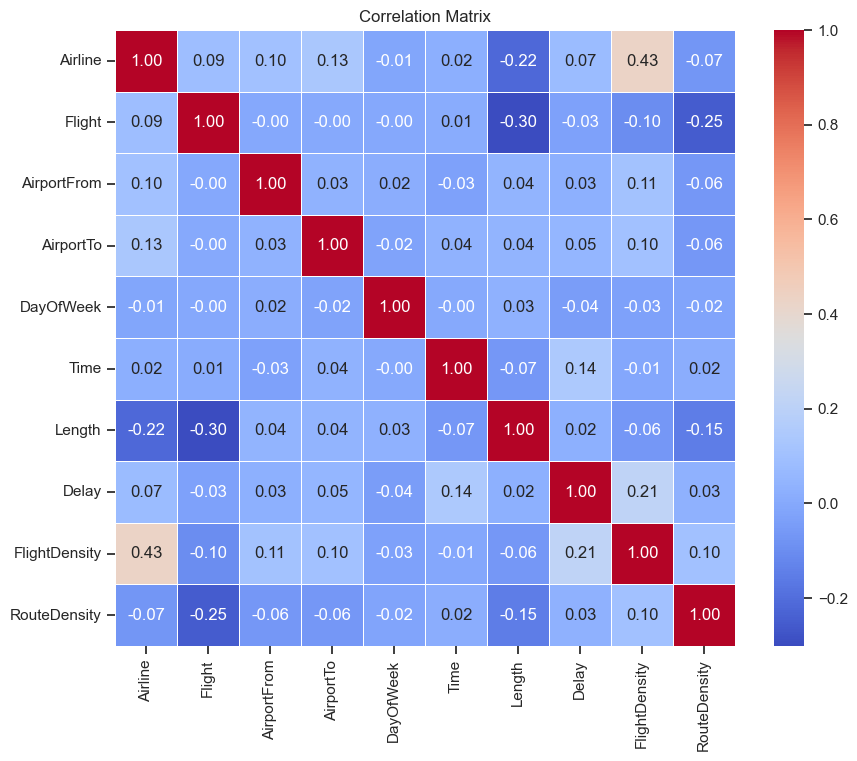

In [895]:
# Correlation matrix

correlation_matrix = dataset.corr(numeric_only=True)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


## MODEL

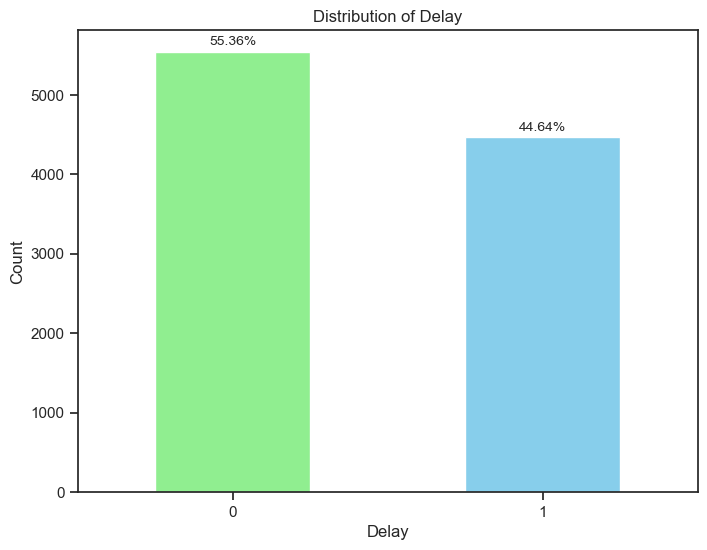

In [891]:
# Randomly sample 10,000 recoreds from the dataset
sampled_df = dataset.sample(n=10000, random_state=42)

# populate the dataset of the model with the sampled dataset
dataset = sampled_df


# sampled_df is the DataFrame with the sampled 10,000 records
delay_counts = sampled_df['Delay'].value_counts()

# Calculate the percentages
total_records = len(sampled_df)
percentages = (delay_counts / total_records) * 100

# Assign colors based on delay status
colors = ['skyblue' if i == 1 else 'lightgreen' for i in delay_counts.index]

# Plot the distribution using a bar chart
plt.figure(figsize=(8, 6))
ax = delay_counts.plot(kind='bar', color=colors)
plt.xlabel('Delay')
plt.ylabel('Count')
plt.title('Distribution of Delay')
plt.xticks(rotation=0)

# Display the percentage on top of each bar
for i, v in enumerate(percentages):
    ax.text(i, delay_counts[i] + 50, f'{v:.2f}%', ha='center', va='bottom', fontsize=10)

plt.show()

### Random Forest 

In [892]:
start_time = time.time()
# Use all columns except 'Delay' as features (X)
X = dataset.drop('Delay', axis=1)
# Delay' is the target variable (y)
y = dataset['Delay']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum samples required at each leaf node
}

# Create a Memory object to handle caching and memory management
memory = Memory(location='./cachedir', verbose=0)

# Function to create and fit RandomForestClassifier
@memory.cache
def fit_random_forest(params, X_train, y_train):
    random_forest = RandomForestClassifier(**params)
    random_forest.fit(X_train, y_train)
    return random_forest

# Initialize RandomForestClassifier
random_forest = RandomForestClassifier()

# Initialize GridSearchCV with RandomForestClassifier as the estimator
with parallel_backend('threading', n_jobs=-1):
    grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)

# Print the best hyperparameters found by the grid search
print("Best Hyperparameters:")
print(grid_search.best_params_)

# Predict on the testing set using the best model from the grid search
best_random_forest = grid_search.best_estimator_
predictions = best_random_forest.predict(X_test)

# Get confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)

end_time = time.time()
duration = end_time - start_time

print('Accuracy:', accuracy)

# Print a classification report
print(classification_report(y_test, predictions))
print(f'Time take to run in seconds {duration}')

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Hyperparameters:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy: 0.6376666666666667
              precision    recall  f1-score   support

           0       0.63      0.83      0.71      1636
           1       0.67      0.41      0.51      1364

    accuracy                           0.64      3000
   macro avg       0.65      0.62      0.61      3000
weighted avg       0.64      0.64      0.62      3000

Time take to run in seconds 88.69643092155457


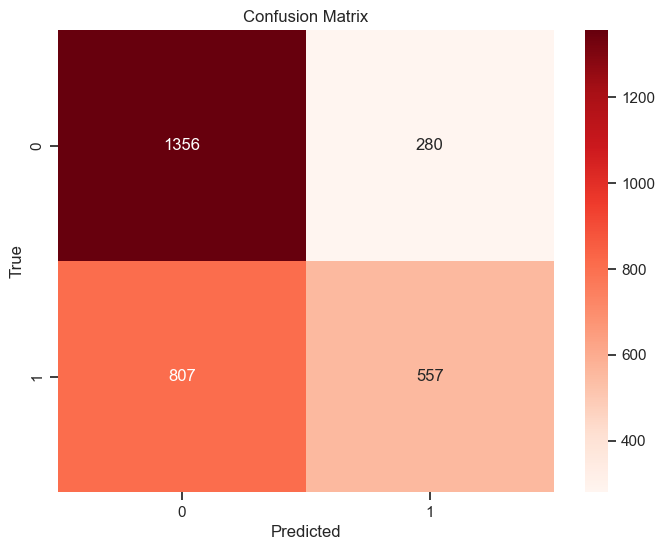

In [898]:
# Confusion Matrix
# Plot confusion matrix with colors
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

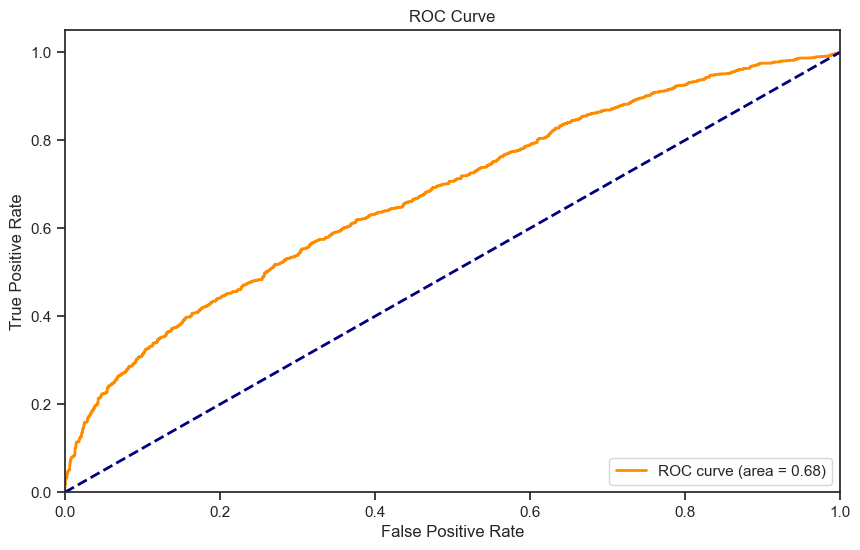

Feature Importances:
Time: 0.21071471264884195
Flight: 0.1370657239629173
FlightDensity: 0.12905162564445505
Length: 0.11296293711320919
RouteDensity: 0.09906203669919102
AirportFrom: 0.0978206194375194
AirportTo: 0.08625805059853336
Airline: 0.07278787690303569
DayOfWeek: 0.054276416992296996


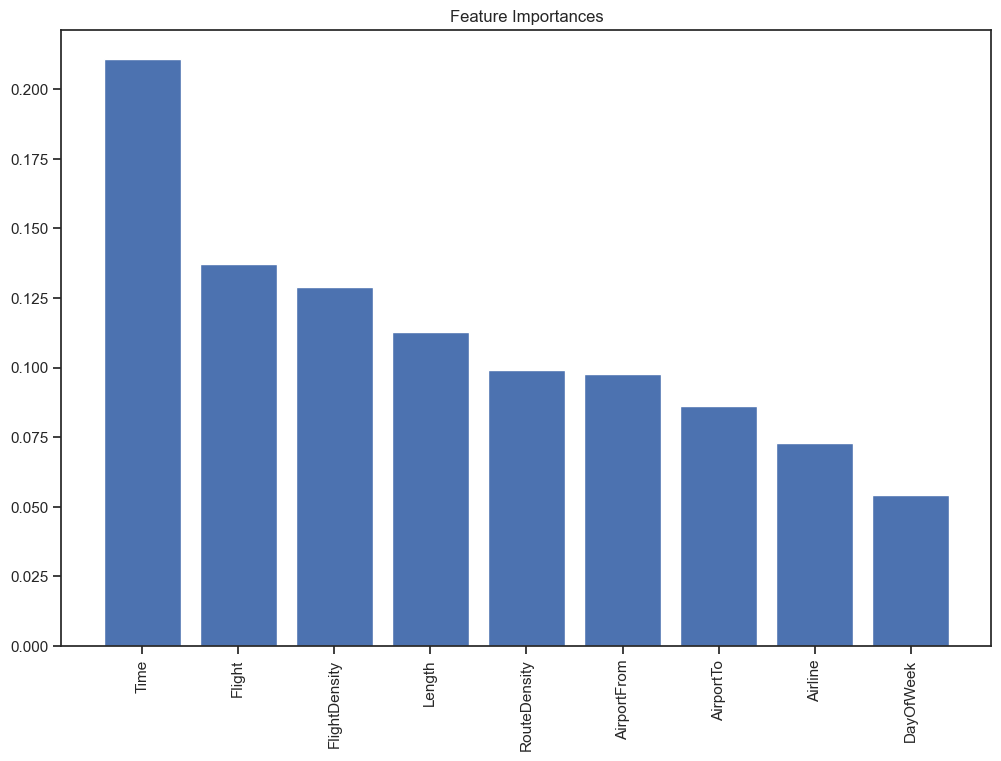

In [894]:
# Plot ROC curve
y_probs = best_random_forest.predict_proba(X_test)[:, 1]  # Probabilities for positive class
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Calculate feature importances
feature_importances = best_random_forest.feature_importances_
feature_names = X.columns

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Print feature importance
print('Feature Importances:')
for i in range(len(feature_names)):
    print(f"{feature_names[indices[i]]}: {feature_importances[indices[i]]}")

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(len(feature_names)), feature_importances[indices])
plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=90)
plt.show()